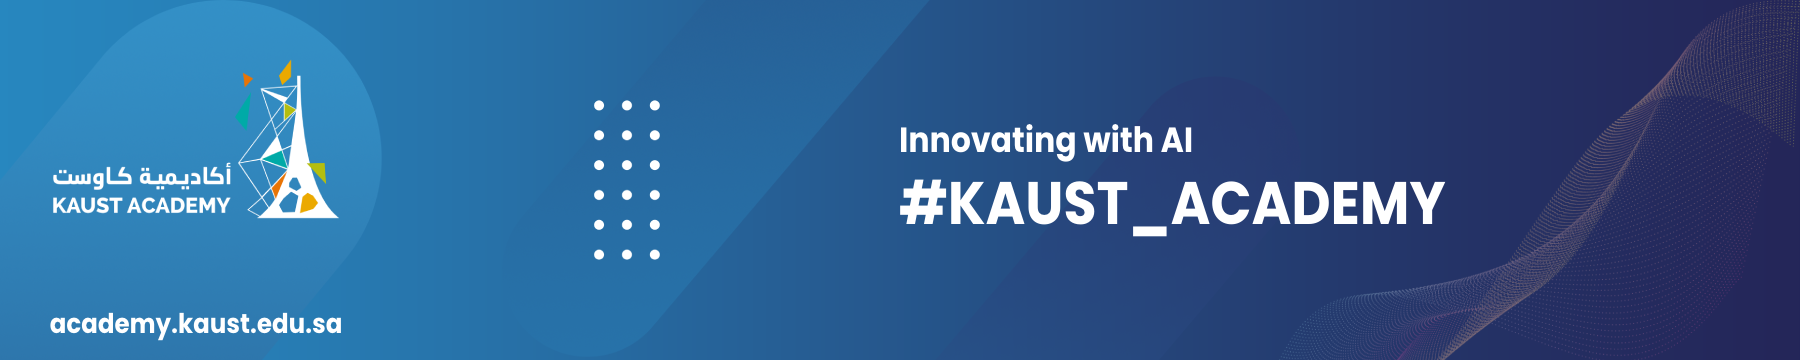

In [ ]:
from IPython.display import clear_output

In [ ]:
%pip install gymnasium stable-baselines3 panda_gym

clear_output()

In [ ]:
# %pip install numpy matplotlib

# Content

In this demo we will use the Soft Actor Critic algorithm to solve the **Panda Pick and Place** Environment. We will use Stable baselines3's implementation of SAC. The Panda pick and place environment is found in panda-gym, which provides some robotics environments in pybullet simulation as gym environments.

In the Panda Pick and Place environment, a robotic arm needs to learn to pick an object on the table and place it on the goal position (near another object in this environment). The actions control the robotic arm.

Here is a biref detail of the actions and rewards of the environment:

| **Aspect**               | **Description**                                                                                                                                                           |
|--------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Actions**              |                                                                                                                                                                           |
| Cartesian End-Effector Movements | Controls the position and orientation of the robot's end-effector (e.g., x, y, z coordinates and roll, pitch, yaw).                                                        |
| Joint Movements          | Directly controls the individual joint angles of the robot arm by specifying the target positions for each joint.                                                          |
| Gripper Control          | Controls the opening and closing of the gripper, which is crucial for grasping and releasing objects.                                                                      |
| Discrete or Continuous Actions | The action space can be either discrete (specific predefined movements) or continuous (exact positions or velocities).                                                         |
| **Rewards**              |                                                                                                                                                                           |
| Distance to Target       | Rewards (or penalties) based on the distance between the object and the target location. As the object gets closer to the target, the reward increases.                    |
| Grasp Success            | Rewards for successfully grasping the object. Typically a binary reward (e.g., +1 for a successful grasp, 0 otherwise).                                                    |
| Placement Success        | Rewards for successfully placing the object at the target location, often a significant reward indicating task completion.                                                 |
| Intermediate Rewards     | Rewards for intermediate steps such as moving the end-effector close to the object, aligning the gripper, or lifting the object off the table.                             |
| Penalties                | Penalties for undesirable actions such as dropping the object, moving away from the target, or colliding with the environment.                                             |


![PandaPickAndPlace Image](https://github.com/qgallouedec/panda-gym/raw/master/docs/_static/img/pickandplace.png)

In [ ]:
import numpy as np

import gymnasium as gym
import panda_gym

from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.her import HerReplayBuffer

from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def frames_to_video(frames, fps=24):
    fig = plt.figure(figsize=(frames[0].shape[1] / 100, frames[0].shape[0] / 100), dpi=100)
    ax = plt.axes()
    ax.set_axis_off()

    if len(frames[0].shape) == 2:  # Grayscale image
        im = ax.imshow(frames[0], cmap='gray')
    else:  # Color image
        im = ax.imshow(frames[0])

    def init():
        if len(frames[0].shape) == 2:
            im.set_data(frames[0], cmap='gray')
        else:
            im.set_data(frames[0])
        return im,

    def update(frame):
        if len(frames[frame].shape) == 2:
            im.set_data(frames[frame], cmap='gray')
        else:
            im.set_data(frames[frame])
        return im,

    interval = 1000 / fps
    anim = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=True, interval=interval)
    plt.close()
    return HTML(anim.to_html5_video())

## Creating the environment

In [ ]:
def make_env(render_mode="rgb_array"):

    env = gym.make('PandaPickAndPlace-v3', render_mode=render_mode)
    return env

In [ ]:
# Create the environment
env = DummyVecEnv([make_env for _ in range(4)])  # adjust accoring to available ram
num_actions = env.action_space.shape[0]

In [ ]:
env.action_space

Box(-1.0, 1.0, (4,), float32)

In [ ]:
env.observation_space  # position of object, position of target, state of robotic arm

Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (19,), float32))

## Creating and training model

In [ ]:
hyper_params = {
    'batch_size': 2048,
    'buffer_size': 1000000,
    'gamma': 0.95,
    'learning_rate': 0.001,
    'policy': 'MultiInputPolicy',  # Multi input policy because each observation is a dict of 3 different inputs.
    'policy_kwargs': {'net_arch': [512, 512, 512], 'n_critics': 2},
    'replay_buffer_class': HerReplayBuffer,
    'replay_buffer_kwargs': {'goal_selection_strategy': 'future', 'n_sampled_goal': 4},
    'tau': 0.05,
}

In [ ]:
model = SAC(env=env, learning_starts=10000, **hyper_params)

In [ ]:
clear_output()
model.learn(total_timesteps=int(1e6), progress_bar=True)

Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

KeyboardInterrupt: 

## Evaluating and visualizing the results

In [ ]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f}")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation 
environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and 
rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(

Mean reward: -45.00

In [ ]:
t_env = DummyVecEnv([lambda: make_env(render_mode="rgb_array")])
state = t_env.reset()
frames = []

while True:
    action, _ = model.predict(state)
    state_next, r, done, info = t_env.step(action)
    frames.append(t_env.render())
    state = state_next
    if done:
        break

t_env.close()

In [ ]:
frames_to_video(frames, fps=5)

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):